In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta

from cosinorage.dataloaders import NHANESDataLoader, plot_orig_enmo, plot_enmo, plot_orig_enmo_freq
from cosinorage.features import WearableFeatures, plot_sleep_predictions, plot_cosinor

%load_ext autoreload
%autoreload 2

In [2]:
reload_nhanes = True

In [3]:
if reload_nhanes:
    nhanes_loader = NHANESDataLoader(nhanes_file_dir='../data/nhanes/', person_id=62164, verbose=True)
    with open("pickle/nhanes_loader.pkl", "wb") as file:
        pickle.dump(nhanes_loader, file)
else:
    with open("pickle/nhanes_loader.pkl", "rb") as file:
        nhanes_loader = pickle.load(file)

Found 1 versions of NHANES data


Reading day-level files: 100%|██████████| 1/1 [00:00<00:00, 27.32it/s]


Read 9 day-level records for person 62164


Processing chunks for version G: 782it [01:04, 12.15it/s], ?it/s]
Reading minute-level files: 100%|██████████| 1/1 [01:04<00:00, 64.35s/it]


Read 11529 minute-level records for person 62164


Reading header files: 100%|██████████| 1/1 [00:00<00:00, 111.35it/s]


Merged day- and minute-level data for person 62164
Renamed columns and set timestamp index for person 62164
Calculated ENMO for person 62164
Loaded 10080 minute-level ENMO records from ../data/nhanes/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
Filtered out 0 minute-level ENMO records due to filtering for longest consecutive sequence of days
Resampled 10080 to 10080 timestamps
__load_data executed in 64.65 seconds


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/dataloaders/utils/nhanes.py:167: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  _data = _data.resample('1min').interpolate(method='linear').bfill()


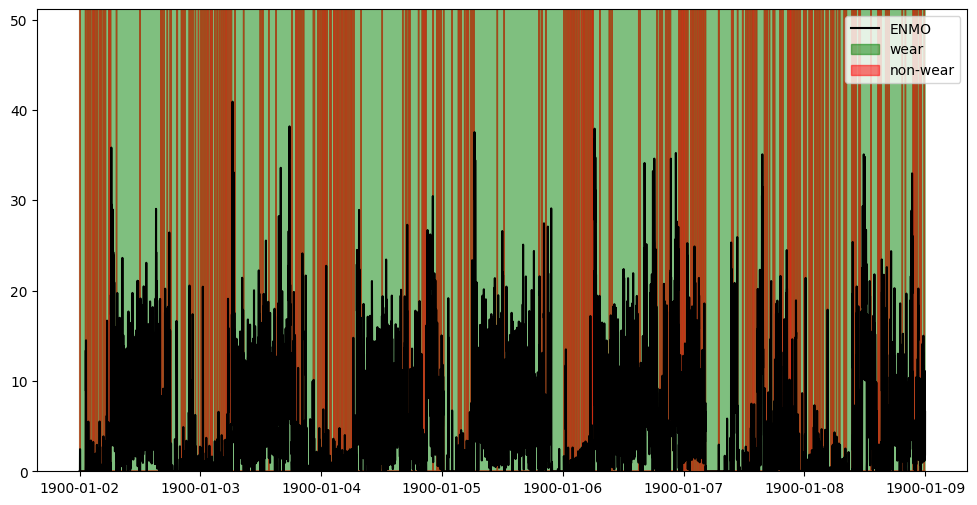

In [4]:
plot_enmo(nhanes_loader)

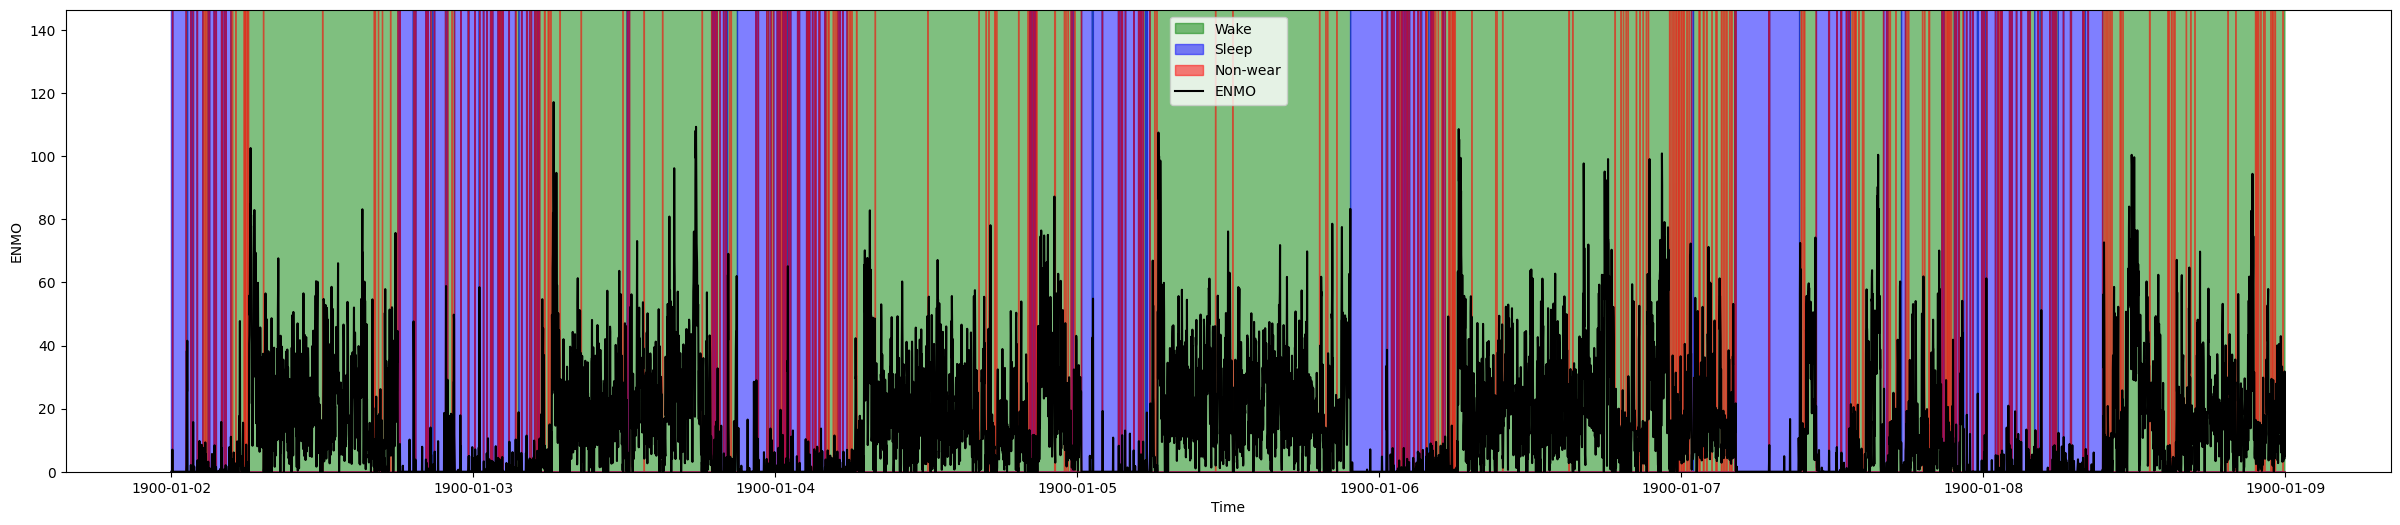

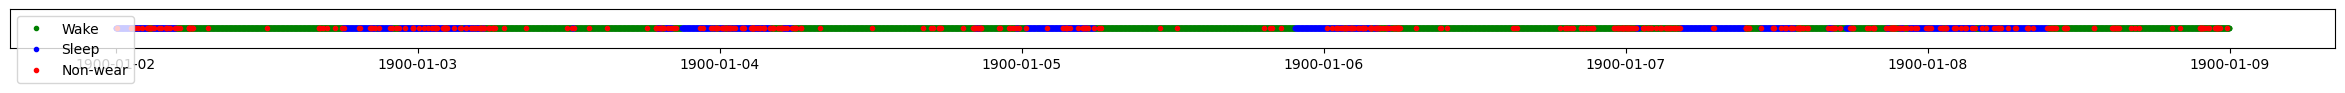

In [5]:
features = WearableFeatures(nhanes_loader)
features.run()
plot_sleep_predictions(features, simple=False)
plot_sleep_predictions(features, simple=True)


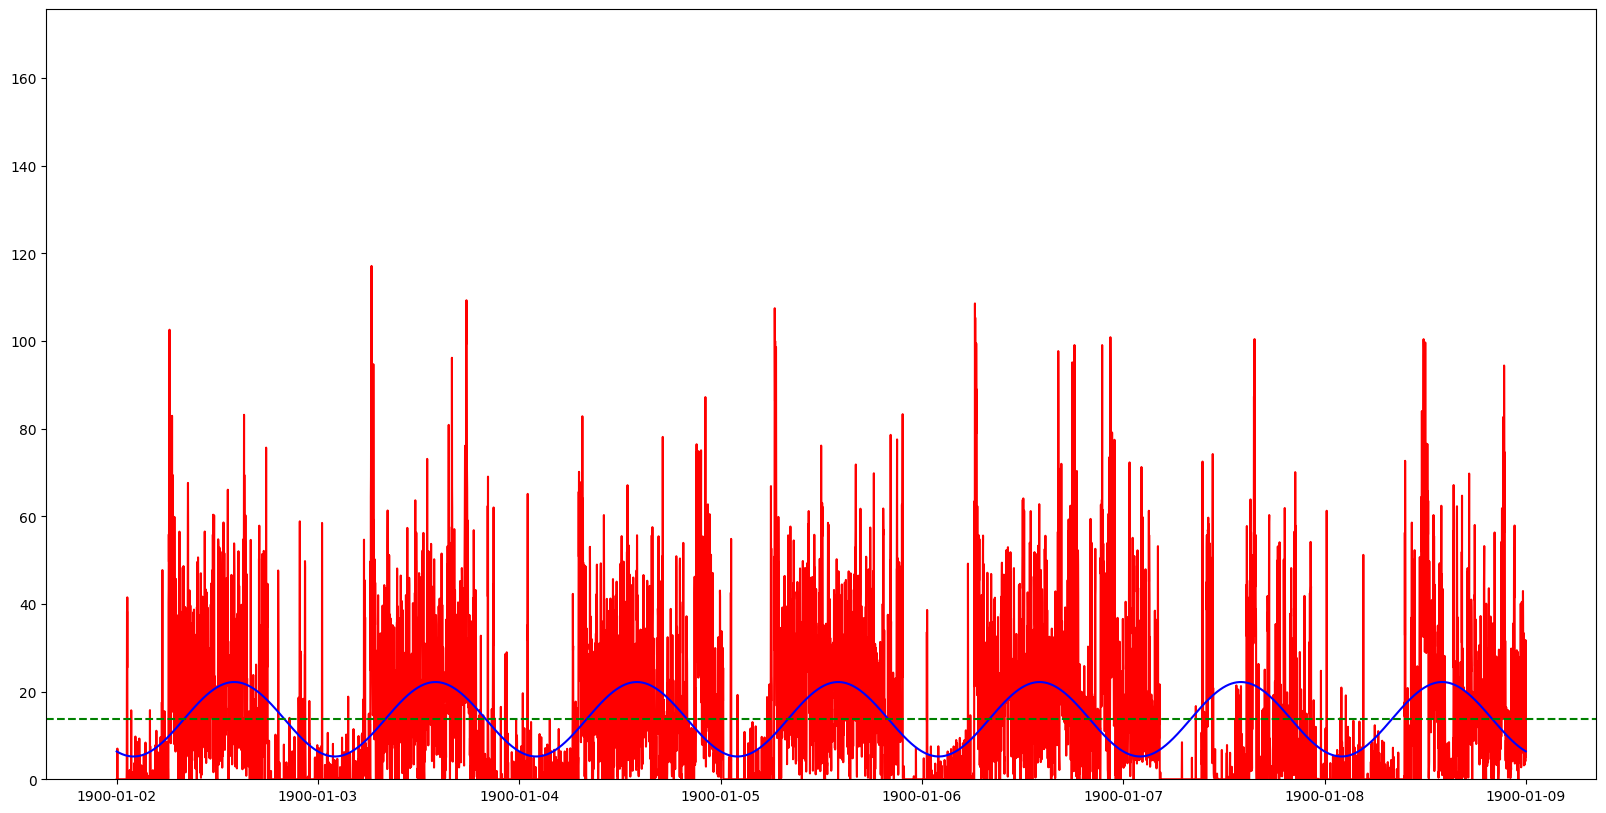

In [6]:
plot_cosinor(features)

In [7]:
features.get_cosinor_features()[1]

{'MESOR': 13.695486175078774,
 'amplitude': 8.495037780375965,
 'acrophase': 3.6730470085059936,
 'acrophase_time': 14.03000610270307}

In [8]:
nhanes_loader.get_meta_data()

{'datasource': 'nhanes',
 'raw_data_frequency': 0.016666666666666666,
 'raw_data_type': 'accelerometer',
 'raw_data_unit': 'm/s^2',
 'n_days': 7}

In [9]:
nhanes_loader.get_raw_data()

,X,Y,Z,wear,sleep,paxpredm,ENMO
TIMESTAMP,,,,,,,
1900-01-02 00:00:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.000000
1900-01-02 00:01:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.000000
1900-01-02 00:02:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.000000
1900-01-02 00:03:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.000000
1900-01-02 00:04:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.000000
...,...,...,...,...,...,...,...
1900-01-08 23:55:00,8.657000e+00,3.093000e+00,4.365000e+00,1,0,1,9.176616
1900-01-08 23:56:00,1.529000e+00,1.496000e+00,1.164000e+00,1,0,1,1.435314
1900-01-08 23:57:00,8.706000e+00,5.995000e+00,5.882000e+00,1,0,1,11.096792
